# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

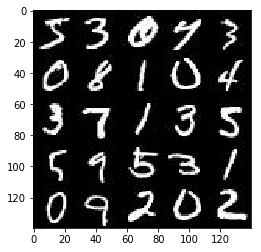

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

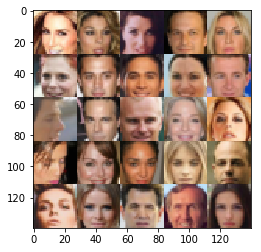

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    input_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_images')
    z_input = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return (input_images, z_input, learning_rate)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [20]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    # Hyperparameter to control leaky ReLU for the discriminator
    ALPHA_D = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        #Layer 1
        # Input layer is 28x28x(number of colour channels)
        # No batch normalization in the first layer
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(ALPHA_D * conv1, conv1)
        # Add dropout
        dropout1 = tf.layers.dropout(relu1, rate=0.3)
        #14x14x64 now
        
        # Layer 2
        conv2 = tf.layers.conv2d(dropout1, 128, 5, strides=2, padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(ALPHA_D * bn2, bn2)
        # Add dropout
        dropout2 = tf.layers.dropout(relu2, rate=0.3)
        #7x7x128 now
        
        # Layer 3
        conv3 = tf.layers.conv2d(dropout2, 256, 5, strides=2, padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(ALPHA_D * bn3, bn3)
        # Add dropout
        dropout3 = tf.layers.dropout(relu3, rate=0.3)
        #4x4x256 now

        # Layer 4
        # Get logits and sigmoid output
        flat = tf.contrib.layers.flatten(dropout3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [21]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # Hyperparameter to control leaky ReLU for generator
    ALPHA_G = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # Layer 1
        # Fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Flatten
        flat = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(flat, training=is_train)
        relu1 = tf.maximum(ALPHA_G * bn1, bn1)
        # Add dropout
        dropout1 = tf.layers.dropout(relu1, rate=0.3)
        # 7x7x512 now
        
        # Layer 2
        # Convolution transpose.
        convt2 = tf.layers.conv2d_transpose(dropout1, 256, 5, strides=2, padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(convt2, training=is_train)
        relu2 = tf.maximum(ALPHA_G * bn2, bn2)
        # Add dropout
        dropout2 = tf.layers.dropout(relu2, rate=0.3)
        # 14x14x256 now
        
        # Layer 3
        # Convolution transpose.
        convt3 = tf.layers.conv2d_transpose(dropout2, 128, 5, strides=2, padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(convt3, training=is_train)
        relu3 = tf.maximum(ALPHA_G * bn3, bn3)
        # Add dropout
        dropout3 = tf.layers.dropout(relu3, rate=0.3)
        # 28x28x256 now
        
        # Layer 4
        # Output layer, 28x28xout_channel_dim. 
        # Use stride 1 to add an extra layer to model and maintain width and height.
        logits = tf.layers.conv2d_transpose(dropout3, out_channel_dim, 5, strides=1, padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28xout_channel_dim now (stride of 1 used)
        
        out = tf.tanh(logits)
        
    return (out)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Notes on the Architecture
Both Discriminator and Generator have 4 layers. This is the same as the number of layers in the network in Radford, Metz and Chintala paper https://arxiv.org/pdf/1511.06434.pdf, although the data (including image size) is different in this case, and that makes some aspects of the architecture (image width and height) different.
The model seems to work best when the alpha values for the Discriminator and Generator are close but not equal, especially if alpha for the discriminator is smaller than alpha for the generator (although the other way around also works). Possibly this difference introduces a little extra noise into the model which helps start the learning process.

### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    # Label smoothing hyperparameter
    SMOOTH = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits
                             (logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - SMOOTH)))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits
                             (logits=d_logits_fake, labels=tf.zeros_like(d_logits_real) * (1 - SMOOTH)))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits
                             (logits=d_logits_fake, labels=tf.ones_like(d_logits_fake) * (1 - SMOOTH)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    PRINT_EVERY = 10 #Steps between print of training data
    SHOW_EVERY = 100 #Steps between drawing of generator output
    
    input_real, input_z, lr_ph = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr_ph, beta1)
    
    # Count steps to decide when to print out latest progress statistics
    steps = 0
    # Store loss data to plot in a graph
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Scale batch image data up from range -0.5, 0.5 to range -1, 1
                batch_images = batch_images * 2

                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr_ph: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr_ph: learning_rate})

                # Print data about training progress
                if steps % PRINT_EVERY == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}, step {}...".format(epoch_i+1, epochs, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save loss data to plot later.
                    losses.append((train_loss_d, train_loss_g))
                
                # Generate sample images
                if steps % SHOW_EVERY == 0:
                    show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)
    
    # Plot a graph of the Generator and Discriminator loss to determine how well they are working.
    fig, ax = pyplot.subplots()
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [ ]:
# Slightly modified from the values in the Radford, Metz and Chintala paper https://arxiv.org/pdf/1511.06434.pdf
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

The x axis on the graph above shows tens of steps. Though the loss of both the Generator and Discriminator are quite variable, the graph shows that the Generator loss generally settles down at a lower value than the Discriminator loss. This suggests the model is working reasonably. Some of the generated digits in the later inferences (though not all of them) do resemble handwritten digits, e.g. 4 and 0 are visible in the last set.

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1, step 10... Discriminator Loss: 0.4713... Generator Loss: 2.7884
Epoch 1/1, step 20... Discriminator Loss: 4.4066... Generator Loss: 0.5590
Epoch 1/1, step 30... Discriminator Loss: 1.6247... Generator Loss: 0.7313
Epoch 1/1, step 40... Discriminator Loss: 1.4478... Generator Loss: 0.7330
Epoch 1/1, step 50... Discriminator Loss: 1.7795... Generator Loss: 0.5258
Epoch 1/1, step 60... Discriminator Loss: 1.7241... Generator Loss: 0.5288
Epoch 1/1, step 70... Discriminator Loss: 1.4664... Generator Loss: 0.7433
Epoch 1/1, step 80... Discriminator Loss: 1.5946... Generator Loss: 0.5893
Epoch 1/1, step 90... Discriminator Loss: 1.4695... Generator Loss: 0.8058
Epoch 1/1, step 100... Discriminator Loss: 1.5038... Generator Loss: 0.8571


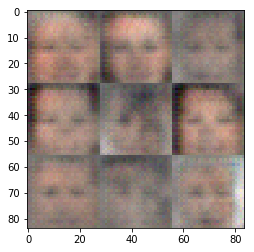

Epoch 1/1, step 110... Discriminator Loss: 1.4017... Generator Loss: 0.7488
Epoch 1/1, step 120... Discriminator Loss: 1.5137... Generator Loss: 0.7049
Epoch 1/1, step 130... Discriminator Loss: 1.4261... Generator Loss: 0.6943
Epoch 1/1, step 140... Discriminator Loss: 1.4577... Generator Loss: 0.8022
Epoch 1/1, step 150... Discriminator Loss: 1.4520... Generator Loss: 0.6977
Epoch 1/1, step 160... Discriminator Loss: 1.4536... Generator Loss: 0.7686
Epoch 1/1, step 170... Discriminator Loss: 1.4743... Generator Loss: 0.7576
Epoch 1/1, step 180... Discriminator Loss: 1.4331... Generator Loss: 0.7559
Epoch 1/1, step 190... Discriminator Loss: 1.5372... Generator Loss: 0.6275
Epoch 1/1, step 200... Discriminator Loss: 1.4664... Generator Loss: 0.6717


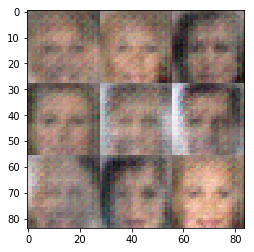

Epoch 1/1, step 210... Discriminator Loss: 1.5170... Generator Loss: 1.0219
Epoch 1/1, step 220... Discriminator Loss: 1.4095... Generator Loss: 0.8716
Epoch 1/1, step 230... Discriminator Loss: 1.4273... Generator Loss: 0.6578
Epoch 1/1, step 240... Discriminator Loss: 1.4469... Generator Loss: 0.7867
Epoch 1/1, step 250... Discriminator Loss: 1.4262... Generator Loss: 0.6867
Epoch 1/1, step 260... Discriminator Loss: 1.4711... Generator Loss: 0.8151
Epoch 1/1, step 270... Discriminator Loss: 1.4104... Generator Loss: 0.7366
Epoch 1/1, step 280... Discriminator Loss: 1.3892... Generator Loss: 0.7801
Epoch 1/1, step 290... Discriminator Loss: 1.4109... Generator Loss: 0.7727
Epoch 1/1, step 300... Discriminator Loss: 1.4259... Generator Loss: 0.7555


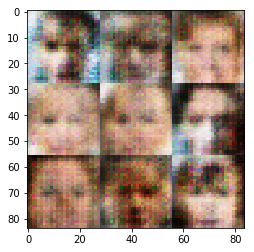

Epoch 1/1, step 310... Discriminator Loss: 1.4272... Generator Loss: 0.7000
Epoch 1/1, step 320... Discriminator Loss: 1.4231... Generator Loss: 0.7806
Epoch 1/1, step 330... Discriminator Loss: 1.4204... Generator Loss: 0.7848
Epoch 1/1, step 340... Discriminator Loss: 1.4113... Generator Loss: 0.7693
Epoch 1/1, step 350... Discriminator Loss: 1.4175... Generator Loss: 0.8519
Epoch 1/1, step 360... Discriminator Loss: 1.4076... Generator Loss: 0.7727
Epoch 1/1, step 370... Discriminator Loss: 1.3477... Generator Loss: 0.8814
Epoch 1/1, step 380... Discriminator Loss: 1.4167... Generator Loss: 0.7251
Epoch 1/1, step 390... Discriminator Loss: 1.4272... Generator Loss: 0.7395
Epoch 1/1, step 400... Discriminator Loss: 1.4223... Generator Loss: 0.7993


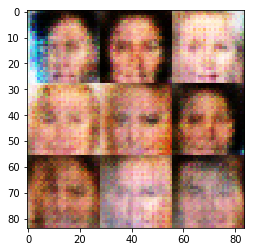

Epoch 1/1, step 410... Discriminator Loss: 1.3942... Generator Loss: 0.8981
Epoch 1/1, step 420... Discriminator Loss: 1.4219... Generator Loss: 0.8395
Epoch 1/1, step 430... Discriminator Loss: 1.3954... Generator Loss: 0.8063
Epoch 1/1, step 440... Discriminator Loss: 1.4468... Generator Loss: 0.7727
Epoch 1/1, step 450... Discriminator Loss: 1.3958... Generator Loss: 0.7877
Epoch 1/1, step 460... Discriminator Loss: 1.4627... Generator Loss: 0.7894
Epoch 1/1, step 470... Discriminator Loss: 1.3682... Generator Loss: 0.8657
Epoch 1/1, step 480... Discriminator Loss: 1.4302... Generator Loss: 0.7238
Epoch 1/1, step 490... Discriminator Loss: 1.4071... Generator Loss: 0.7719
Epoch 1/1, step 500... Discriminator Loss: 1.4146... Generator Loss: 0.7440


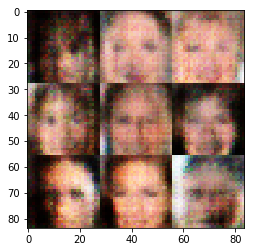

Epoch 1/1, step 510... Discriminator Loss: 1.4482... Generator Loss: 0.7009
Epoch 1/1, step 520... Discriminator Loss: 1.4273... Generator Loss: 0.7515
Epoch 1/1, step 530... Discriminator Loss: 1.3945... Generator Loss: 0.8387
Epoch 1/1, step 540... Discriminator Loss: 1.3301... Generator Loss: 0.8238
Epoch 1/1, step 550... Discriminator Loss: 1.3691... Generator Loss: 0.8047
Epoch 1/1, step 560... Discriminator Loss: 1.3845... Generator Loss: 0.8585
Epoch 1/1, step 570... Discriminator Loss: 1.4069... Generator Loss: 0.7431
Epoch 1/1, step 580... Discriminator Loss: 1.4618... Generator Loss: 0.7408
Epoch 1/1, step 590... Discriminator Loss: 1.4208... Generator Loss: 0.7818
Epoch 1/1, step 600... Discriminator Loss: 1.4279... Generator Loss: 0.6779


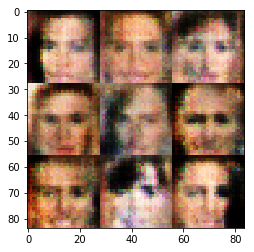

Epoch 1/1, step 610... Discriminator Loss: 1.3793... Generator Loss: 0.8193
Epoch 1/1, step 620... Discriminator Loss: 1.4375... Generator Loss: 0.7170
Epoch 1/1, step 630... Discriminator Loss: 1.4068... Generator Loss: 0.8280
Epoch 1/1, step 640... Discriminator Loss: 1.4091... Generator Loss: 0.7863
Epoch 1/1, step 650... Discriminator Loss: 1.4373... Generator Loss: 0.7549
Epoch 1/1, step 660... Discriminator Loss: 1.3681... Generator Loss: 0.7807
Epoch 1/1, step 670... Discriminator Loss: 1.3782... Generator Loss: 0.8345
Epoch 1/1, step 680... Discriminator Loss: 1.4055... Generator Loss: 0.7689
Epoch 1/1, step 690... Discriminator Loss: 1.3753... Generator Loss: 0.7736
Epoch 1/1, step 700... Discriminator Loss: 1.3997... Generator Loss: 0.7387


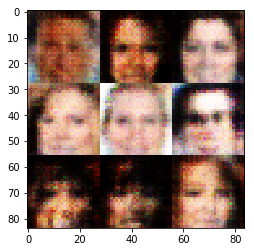

Epoch 1/1, step 710... Discriminator Loss: 1.3751... Generator Loss: 0.8185
Epoch 1/1, step 720... Discriminator Loss: 1.4046... Generator Loss: 0.7357
Epoch 1/1, step 730... Discriminator Loss: 1.4003... Generator Loss: 0.7655
Epoch 1/1, step 740... Discriminator Loss: 1.3557... Generator Loss: 0.8717
Epoch 1/1, step 750... Discriminator Loss: 1.3683... Generator Loss: 0.7488
Epoch 1/1, step 760... Discriminator Loss: 1.4104... Generator Loss: 0.8566
Epoch 1/1, step 770... Discriminator Loss: 1.3993... Generator Loss: 0.7665
Epoch 1/1, step 780... Discriminator Loss: 1.4137... Generator Loss: 0.8617
Epoch 1/1, step 790... Discriminator Loss: 1.4261... Generator Loss: 0.6809
Epoch 1/1, step 800... Discriminator Loss: 1.3628... Generator Loss: 0.7354


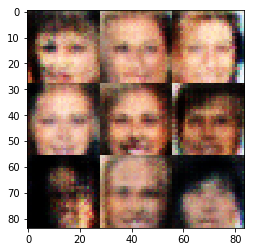

Epoch 1/1, step 810... Discriminator Loss: 1.4040... Generator Loss: 0.8587
Epoch 1/1, step 820... Discriminator Loss: 1.4038... Generator Loss: 0.7646
Epoch 1/1, step 830... Discriminator Loss: 1.3845... Generator Loss: 0.7494
Epoch 1/1, step 840... Discriminator Loss: 1.3993... Generator Loss: 0.8339
Epoch 1/1, step 850... Discriminator Loss: 1.3990... Generator Loss: 0.7188
Epoch 1/1, step 860... Discriminator Loss: 1.3873... Generator Loss: 0.7502
Epoch 1/1, step 870... Discriminator Loss: 1.3888... Generator Loss: 0.7908
Epoch 1/1, step 880... Discriminator Loss: 1.3662... Generator Loss: 0.8130
Epoch 1/1, step 890... Discriminator Loss: 1.3798... Generator Loss: 0.7911
Epoch 1/1, step 900... Discriminator Loss: 1.4296... Generator Loss: 0.8148


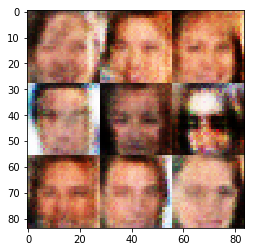

Epoch 1/1, step 910... Discriminator Loss: 1.4195... Generator Loss: 0.8896
Epoch 1/1, step 920... Discriminator Loss: 1.3928... Generator Loss: 0.7823
Epoch 1/1, step 930... Discriminator Loss: 1.3665... Generator Loss: 0.7794
Epoch 1/1, step 940... Discriminator Loss: 1.3805... Generator Loss: 0.8530
Epoch 1/1, step 950... Discriminator Loss: 1.3951... Generator Loss: 0.7673
Epoch 1/1, step 960... Discriminator Loss: 1.3762... Generator Loss: 0.7401
Epoch 1/1, step 970... Discriminator Loss: 1.3569... Generator Loss: 0.8570
Epoch 1/1, step 980... Discriminator Loss: 1.4147... Generator Loss: 0.7949
Epoch 1/1, step 990... Discriminator Loss: 1.3724... Generator Loss: 0.8028
Epoch 1/1, step 1000... Discriminator Loss: 1.4045... Generator Loss: 0.8422


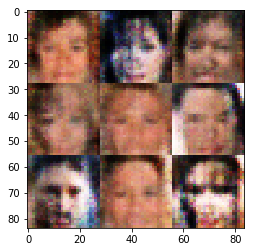

Epoch 1/1, step 1010... Discriminator Loss: 1.3929... Generator Loss: 0.7948
Epoch 1/1, step 1020... Discriminator Loss: 1.3687... Generator Loss: 0.8586
Epoch 1/1, step 1030... Discriminator Loss: 1.3901... Generator Loss: 0.7551
Epoch 1/1, step 1040... Discriminator Loss: 1.3620... Generator Loss: 0.8469
Epoch 1/1, step 1050... Discriminator Loss: 1.4439... Generator Loss: 0.7678
Epoch 1/1, step 1060... Discriminator Loss: 1.3868... Generator Loss: 0.7881
Epoch 1/1, step 1070... Discriminator Loss: 1.4393... Generator Loss: 0.7404
Epoch 1/1, step 1080... Discriminator Loss: 1.3923... Generator Loss: 0.7335
Epoch 1/1, step 1090... Discriminator Loss: 1.3805... Generator Loss: 0.7586
Epoch 1/1, step 1100... Discriminator Loss: 1.4347... Generator Loss: 0.7837


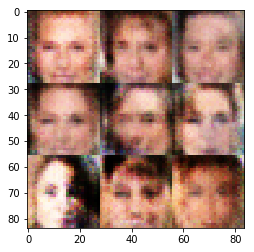

Epoch 1/1, step 1110... Discriminator Loss: 1.4632... Generator Loss: 0.7853
Epoch 1/1, step 1120... Discriminator Loss: 1.3782... Generator Loss: 0.8463
Epoch 1/1, step 1130... Discriminator Loss: 1.4127... Generator Loss: 0.7138
Epoch 1/1, step 1140... Discriminator Loss: 1.3850... Generator Loss: 0.8187
Epoch 1/1, step 1150... Discriminator Loss: 1.3652... Generator Loss: 0.8103
Epoch 1/1, step 1160... Discriminator Loss: 1.4058... Generator Loss: 0.7817
Epoch 1/1, step 1170... Discriminator Loss: 1.3755... Generator Loss: 0.7484
Epoch 1/1, step 1180... Discriminator Loss: 1.4216... Generator Loss: 0.8165
Epoch 1/1, step 1190... Discriminator Loss: 1.3776... Generator Loss: 0.8154
Epoch 1/1, step 1200... Discriminator Loss: 1.4045... Generator Loss: 0.6970


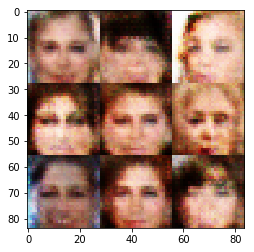

Epoch 1/1, step 1210... Discriminator Loss: 1.3904... Generator Loss: 0.8535
Epoch 1/1, step 1220... Discriminator Loss: 1.4467... Generator Loss: 0.8515
Epoch 1/1, step 1230... Discriminator Loss: 1.3784... Generator Loss: 0.6799
Epoch 1/1, step 1240... Discriminator Loss: 1.3975... Generator Loss: 0.7547
Epoch 1/1, step 1250... Discriminator Loss: 1.3430... Generator Loss: 0.7811
Epoch 1/1, step 1260... Discriminator Loss: 1.4048... Generator Loss: 0.8080
Epoch 1/1, step 1270... Discriminator Loss: 1.4042... Generator Loss: 0.7541
Epoch 1/1, step 1280... Discriminator Loss: 1.4086... Generator Loss: 0.8039
Epoch 1/1, step 1290... Discriminator Loss: 1.3845... Generator Loss: 0.8138
Epoch 1/1, step 1300... Discriminator Loss: 1.4236... Generator Loss: 0.7950


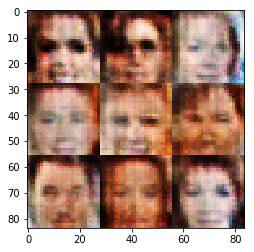

Epoch 1/1, step 1310... Discriminator Loss: 1.4018... Generator Loss: 0.7083
Epoch 1/1, step 1320... Discriminator Loss: 1.3910... Generator Loss: 0.7449
Epoch 1/1, step 1330... Discriminator Loss: 1.3776... Generator Loss: 0.7469
Epoch 1/1, step 1340... Discriminator Loss: 1.3702... Generator Loss: 0.8466
Epoch 1/1, step 1350... Discriminator Loss: 1.4107... Generator Loss: 0.7193
Epoch 1/1, step 1360... Discriminator Loss: 1.3740... Generator Loss: 0.7837
Epoch 1/1, step 1370... Discriminator Loss: 1.3565... Generator Loss: 0.7975
Epoch 1/1, step 1380... Discriminator Loss: 1.3468... Generator Loss: 0.8209
Epoch 1/1, step 1390... Discriminator Loss: 1.3762... Generator Loss: 0.7974
Epoch 1/1, step 1400... Discriminator Loss: 1.3951... Generator Loss: 0.7960


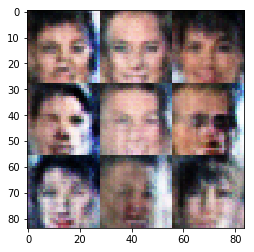

Epoch 1/1, step 1410... Discriminator Loss: 1.3635... Generator Loss: 0.6932
Epoch 1/1, step 1420... Discriminator Loss: 1.3955... Generator Loss: 0.7706
Epoch 1/1, step 1430... Discriminator Loss: 1.4026... Generator Loss: 0.7701
Epoch 1/1, step 1440... Discriminator Loss: 1.3790... Generator Loss: 0.8663
Epoch 1/1, step 1450... Discriminator Loss: 1.3546... Generator Loss: 0.8196
Epoch 1/1, step 1460... Discriminator Loss: 1.4078... Generator Loss: 0.8338
Epoch 1/1, step 1470... Discriminator Loss: 1.3966... Generator Loss: 0.7474
Epoch 1/1, step 1480... Discriminator Loss: 1.3946... Generator Loss: 0.7606
Epoch 1/1, step 1490... Discriminator Loss: 1.4249... Generator Loss: 0.8436
Epoch 1/1, step 1500... Discriminator Loss: 1.3917... Generator Loss: 0.8554


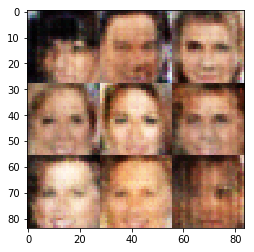

Epoch 1/1, step 1510... Discriminator Loss: 1.3645... Generator Loss: 0.7602
Epoch 1/1, step 1520... Discriminator Loss: 1.4009... Generator Loss: 0.9350
Epoch 1/1, step 1530... Discriminator Loss: 1.3756... Generator Loss: 0.7608
Epoch 1/1, step 1540... Discriminator Loss: 1.3969... Generator Loss: 0.7657
Epoch 1/1, step 1550... Discriminator Loss: 1.3535... Generator Loss: 0.7780
Epoch 1/1, step 1560... Discriminator Loss: 1.3624... Generator Loss: 0.7109
Epoch 1/1, step 1570... Discriminator Loss: 1.3555... Generator Loss: 0.7645
Epoch 1/1, step 1580... Discriminator Loss: 1.3491... Generator Loss: 0.7964


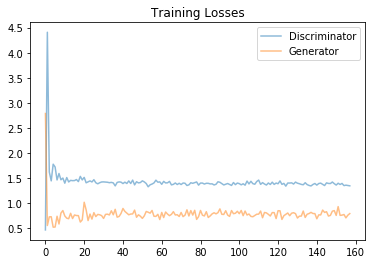

In [26]:
# Using the same hyperparameters as above for the face data.
batch_size = 128
z_dim = 100
learning_rate = 0.0004
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Notes on the Output
The loss of the Generator and Discriminator both seems to converge more quickly for CelebA than the MNIST data and before the end the generated images are blurry but recognizably distinct faces.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.